In [1]:
import os
import numpy as np
import xarray as xr

#import datetime, dateutil

import xmitgcm as xm
from xmitgcm import llcreader
from fsspec.implementations.local import LocalFileSystem

In [ ]:
from dask.distributed import Client, LocalCluster
#
cluster = LocalCluster()
client = Client(cluster)
client

In [4]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 56,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:58520,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 56
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:50918,Total threads: 7
Dashboard: http://127.0.0.1:58947/status,Memory: 12.50 GiB
Nanny: tcp://127.0.0.1:34945,


In [80]:
fs = LocalFileSystem()

root_data_dir = "/home/datawork-lops-osi/equinox/mit4320/"
ref_data_dir = "/dataref/ocean-analysis/intranet/LLC4320_surface/"
bin_data_dir = root_data_dir + "bin/"
bin_grid_dir = bin_data_dir + "grid/"
#
zarr_data_dir = ref_data_dir
zarr_grid = zarr_data_dir + "grid.zarr"
zarr_grid_cons = "/home/datawork-lops-osi/equinox/mit4320/grid_consolidated.zarr"
mask_path = zarr_data_dir + "mask.zarr"

#iter = "0000010512"
iter = "0001490544"
data_dir = f"/home/datawork-lops-osi/equinox/mit4320/bin/{iter}"
store = llcreader.BaseStore(fs, base_path=data_dir, shrunk=True, mask_path=mask_path, grid_path=bin_grid_dir)
model = llcreader.LLC4320Model(store)

In [87]:
ds = model.get_dataset(["Theta", "Salt"], iters=[int(iter)])

/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/xmitgcm/llcreader/llcmodel.py:406: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  return {vname: _facets_to_faces(data, nfaces)
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/xmitgcm/llcreader/llcmodel.py:406: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     a

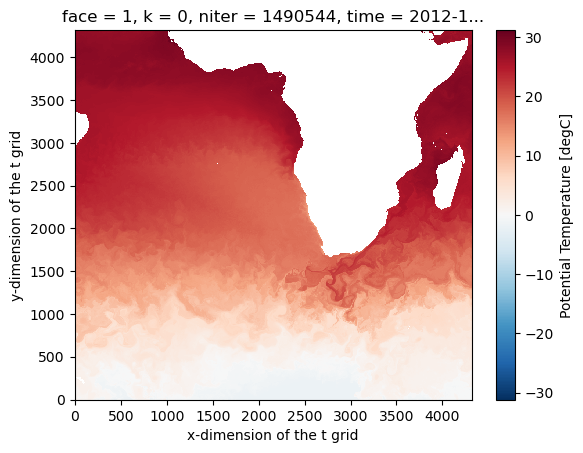

In [88]:
ds.Theta.isel(face=1, i=slice(0,None,4), j=slice(0,None,4), k=0).plot()
#ds.Salt.isel(face=1, i=slice(0,None,4), j=slice(0,None,4), k=0).plot()

In [89]:
ds = (
    ds
    .reset_coords()
    [["Theta", "Salt"]]
    .chunk(dict(i=-1, j=-1, k=1, face=3))
)

In [90]:
ds.to_zarr(os.path.join(data_dir, "tracers.zarr"), mode="w")

In [92]:
grid = xr.open_zarr(zarr_grid_cons)

In [95]:
grid.reset_coords()["dxC"].rename(i_g="i")

<xarray.DataArray 'dxC' (face: 13, j: 4320, i: 4320)>
dask.array<open_dataset-dxC, shape=(13, 4320, 4320), dtype=float32, chunksize=(1, 4320, 4320), chunktype=numpy.ndarray>
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
Attributes:
    coordinate:     YC XG
    long_name:      cell x size
    standard_name:  cell_x_size_at_u_location
    units:          m

In [ ]:
# consolidated grid
ds = xr.open_zarr(zarr_grid)
zarr_grid_cons = "/home/datawork-lops-osi/equinox/mit4320/grid_consolidated.zarr"
ds.to_zarr(zarr_grid_cons, mode="w")